In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym[classic_control]

from pyvirtualdisplay import Display
Display().start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.5).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import random
from collections import deque
import gym
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [3]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


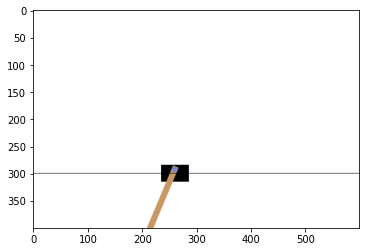

In [4]:
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(50):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)
  # if done:
  #   env.reset()
env.close()

In [5]:
env.observation_space.shape

(4,)

In [6]:
env.action_space.n

2

In [7]:
num_observations = env.observation_space.shape[0]

In [8]:
num_actions = env.action_space.n

In [9]:
model = Sequential()
model.add(Dense(16, input_shape=(1,num_observations)))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

# Neurons == action_space
model.add(Dense(num_actions))
model.add(Activation('linear'))

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 16)             80        
                                                                 
 activation (Activation)     (None, 1, 16)             0         
                                                                 
 dense_1 (Dense)             (None, 1, 32)             544       
                                                                 
 activation_1 (Activation)   (None, 1, 32)             0         
                                                                 
 dense_2 (Dense)             (None, 1, 2)              66        
                                                                 
 activation_2 (Activation)   (None, 1, 2)              0         
                                                                 
Total params: 690
Trainable params: 690
Non-trainable pa

In [11]:
target_model = clone_model(model)

In [12]:
EPOCHS = 1000
BATCH_SIZE = 32
epsilon = 1.0
EPSILON_REDUCE = 0.995
LEARNING_RATE = 0.001
GAMMA = 0.95

In [21]:
def epsilon_greedy_action_selection(model,epsilon,observation):
  if np.random.random() > epsilon:
    prediction = model.predict(observation.reshape(1,1,4),verbose=0)
    action = np.argmax(prediction)
  else:
    action = np.random.randint(0,env.action_space.n)
  return action

In [14]:
replay_buffer = deque(maxlen=20000)
update_target_model = 10

In [15]:
def replay(replay_buffer, batch_size, model, target_model):
    
    # As long as the buffer has not enough elements we do nothing
    if len(replay_buffer) < batch_size: 
        return
    
    # Take a random sample from the buffer with size batch_size
    samples = random.sample(replay_buffer, batch_size)  
    
    # to store the targets predicted by the target network for training
    target_batch = []  
    
    # Efficient way to handle the sample by using the zip functionality
    zipped_samples = list(zip(*samples))  
    states, actions, rewards, new_states, dones = zipped_samples  
    
    # Predict targets for all states from the sample
    targets = target_model.predict(np.array(states),verbose=0)
    
    # Predict Q-Values for all new states from the sample
    q_values = model.predict(np.array(new_states),verbose=0)  
    
    # Now we loop over all predicted values to compute the actual targets
    for i in range(batch_size):  
        
        # Take the maximum Q-Value for each sample
        q_value = max(q_values[i][0])  
        
        # Store the ith target in order to update it according to the formula
        target = targets[i].copy()  
        if dones[i]:
            target[0][actions[i]] = rewards[i]
        else:
            target[0][actions[i]] = rewards[i] + q_value * GAMMA
        target_batch.append(target)

    # Fit the model based on the states and the updated targets for 1 epoch
    model.fit(np.array(states), np.array(target_batch), epochs=1, verbose=0)  


In [16]:
def update_model_handler(epoch, update_target_model, model, target_model):
    if epoch > 0 and epoch % update_target_model == 0:
        target_model.set_weights(model.get_weights())


In [17]:
model.compile(loss='mse',optimizer=(Adam(lr=LEARNING_RATE)))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
best_so_far = 0
for epoch in range(EPOCHS):
    observation = env.reset()  # Get inital state
    
    # Keras expects the input to be of shape [1, X] thus we have to reshape
    observation = observation.reshape([1, 4])  
    done = False  
    
    points = 0
    while not done:  # as long current run is active
        
        # Select action acc. to strategy
        action = epsilon_greedy_action_selection(model, epsilon, observation)
        
        # Perform action and get next state
        next_observation, reward, done, info = env.step(action)  
        next_observation = next_observation.reshape([1, 4])  # Reshape!!
        replay_buffer.append((observation, action, reward, next_observation, done))  # Update the replay buffer
        observation = next_observation  # update the observation
        points+=1

        # Most important step! Training the model by replaying
        replay(replay_buffer, 32, model, target_model)

    
    epsilon *= EPSILON_REDUCE  # Reduce epsilon
    
    # Check if we need to update the target model
    update_model_handler(epoch, update_target_model, model, target_model)
    
    if points > best_so_far:
        best_so_far = points
    if epoch %25 == 0:
        print(f"{epoch}: Points reached: {points} - epsilon: {epsilon} - Best: {best_so_far}")


0: Points reached: 13 - epsilon: 0.9558895783575597 - Best: 13
25: Points reached: 17 - epsilon: 0.8433051360508336 - Best: 52
50: Points reached: 11 - epsilon: 0.7439808620067382 - Best: 52
75: Points reached: 38 - epsilon: 0.6563549768288433 - Best: 52
100: Points reached: 37 - epsilon: 0.5790496471185967 - Best: 137
125: Points reached: 79 - epsilon: 0.510849320360386 - Best: 201
150: Points reached: 95 - epsilon: 0.4506816115185697 - Best: 393
175: Points reached: 259 - epsilon: 0.3976004408064698 - Best: 415
200: Points reached: 190 - epsilon: 0.3507711574848344 - Best: 423
225: Points reached: 291 - epsilon: 0.30945741577570285 - Best: 423
250: Points reached: 345 - epsilon: 0.2730095965279488 - Best: 423
275: Points reached: 278 - epsilon: 0.2408545925762412 - Best: 423
300: Points reached: 285 - epsilon: 0.21248679717794605 - Best: 423
325: Points reached: 254 - epsilon: 0.18746015382974018 - Best: 423
350: Points reached: 201 - epsilon: 0.16538114245489302 - Best: 423
375: Poi

In [ ]:
# Save the model

In [ ]:
observation = env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(300):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = np.argmax(model.predict(observation.reshape([1,4]),verbose=0))
  observation, reward, done, info = env.step(action)
  # if done:
  #   env.reset()
env.close()